In [1]:
import os
import sys
import random
import warnings
import cv2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 608
IMG_HEIGHT = 240
IMG_CHANNELS = 3

TRAIN_PATH='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/input_train/'
TEST_PATH ='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/input_test/'
MASK_TRAIN='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/ex_train/'
# MASK_TEST=r'C:\Users\jmlee\Desktop\4학년 1학기\졸프\U-Net\정맥추출_test'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
tf. version

<module 'tensorflow._api.v1.version' from 'C:\\Users\\jmlee\\anaconda3\\lib\\site-packages\\tensorflow\\_api\\v1\\version\\__init__.py'>

## Train, Test

In [3]:
# #한글이름 사진 로드
from PIL import Image

#gray로 불러와야 threshold  함수 사용가능
def hangulFilePathImageRead2 (filePath ) :  
    stream = open(filePath.encode("utf-8") , "rb")
    bytes = bytearray(stream.read())
    numpyArray = np.asarray(bytes, dtype=np.uint8)

    return cv2.imdecode(numpyArray , cv2.IMREAD_GRAYSCALE)

# def hangulFilePathImageRead (filePath ) :

#     stream = open( filePath.encode("utf-8") , "rb")
#     bytes = bytearray(stream.read())
#     numpyArray = np.asarray(bytes, dtype=np.uint8)

#     return cv2.imdecode(numpyArray , cv2.IMREAD_COLOR)  #3채널로 가져오기

# #train
# if __name__ == '__main__':
#     train_mask_=[]
#     train__=[]
#     for f in os.listdir(TRAIN_PATH):  
#         if f.split('.')[1] =='jpg':
#             filePath = r'C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/정맥전체(.jpg)'+'/'+f
#             train_= hangulFilePathImageRead2(filePath)  #이미지
#             train__.append(train_)
#             train_mask = cv2.adaptiveThreshold(train_,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,19, 15) #마스크
#             train_mask_.append(train_mask)
            
            
            
# #test
# if __name__ == '__main__':
#     test_mask_=[]
#     test__=[]
#     for f_ in os.listdir(TEST_PATH):  
#         if f_.split('.')[1] =='jpg':
#             filePath = (r"C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/input_test"+'/'+f_)  
#             test_ = hangulFilePathImageRead2(filePath)  #이미지
#             test__.append(test_)
#             test_mask = cv2.adaptiveThreshold(test_,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,19, 15)  #마스크
#             test_mask_.append(test_mask)
            
# #             print(f_)

In [4]:
# Get train and test IDs
# train_path=os.walk(TRAIN_PATH)  #agumenatation한것_에러 안남
# train_ids = next(train_path)[2]

train_path=os.walk(TRAIN_PATH) #raw
train_ids= next(train_path)[2]

test_path=os.walk(TEST_PATH)
test_ids = next(test_path)[2]

mask_path=os.walk(MASK_TRAIN)
mask_ids = next(mask_path)[2]

In [5]:
a=np.array(train_ids)
a.shape

(130,)

In [6]:
train_ids

['[SEG]강병준_1_1.jpg',
 '[SEG]강병준_2_1.jpg',
 '[SEG]강병준_3_1.jpg',
 '[SEG]강병준_4_1.jpg',
 '[SEG]강병준_6_1.jpg',
 '[SEG]강병준_7_1.jpg',
 '[SEG]강병준_8_1.jpg',
 '[SEG]강병준_9_1.jpg',
 '[SEG]고유진_1_1.jpg',
 '[SEG]고유진_2_1.jpg',
 '[SEG]고유진_3_1.jpg',
 '[SEG]고유진_4_1.jpg',
 '[SEG]고유진_6_1.jpg',
 '[SEG]고유진_7_1.jpg',
 '[SEG]고유진_8_1.jpg',
 '[SEG]고유진_9_1.jpg',
 '[SEG]김민호_1_1.jpg',
 '[SEG]김민호_2_1.jpg',
 '[SEG]김민호_3_1.jpg',
 '[SEG]김민호_4_1.jpg',
 '[SEG]김민호_6_1.jpg',
 '[SEG]김민호_7_1.jpg',
 '[SEG]김민호_8_1.jpg',
 '[SEG]김민호_9_1.jpg',
 '[SEG]김보나_1_1.jpg',
 '[SEG]김보나_2_1.jpg',
 '[SEG]김보나_3_1.jpg',
 '[SEG]김보나_6_1.jpg',
 '[SEG]김보나_7_1.jpg',
 '[SEG]김보나_8_1.jpg',
 '[SEG]김승용_1_1.jpg',
 '[SEG]김승용_2_1.jpg',
 '[SEG]김승용_3_1.jpg',
 '[SEG]김승용_4_1.jpg',
 '[SEG]김승용_6_1.jpg',
 '[SEG]김승용_7_1.jpg',
 '[SEG]김승용_8_1.jpg',
 '[SEG]김승용_9_1.jpg',
 '[SEG]김유미_1_1.jpg',
 '[SEG]김유미_2_1.jpg',
 '[SEG]김유미_3_1.jpg',
 '[SEG]김유미_6_1.jpg',
 '[SEG]김유미_7_1.jpg',
 '[SEG]김유미_8_1.jpg',
 '[SEG]김주리_1_1.jpg',
 '[SEG]김주리_2_1.jpg',
 '[SEG]김주리_3_1.jpg',
 '[SEG]김주리_4_

In [7]:
mask_ids

['[SEG]강병준_1_1.jpg',
 '[SEG]강병준_2_1 .jpg',
 '[SEG]강병준_3_1 .jpg',
 '[SEG]강병준_4_1 .jpg',
 '[SEG]강병준_6_1 .jpg',
 '[SEG]강병준_7_1 .jpg',
 '[SEG]강병준_8_1 .jpg',
 '[SEG]강병준_9_1 복사본.jpg',
 '[SEG]고유진_1_1 복사본.jpg',
 '[SEG]고유진_2_1 복사본.jpg',
 '[SEG]고유진_3_1 복사본.jpg',
 '[SEG]고유진_4_1 복사본.jpg',
 '[SEG]고유진_6_1 복사본.jpg',
 '[SEG]고유진_7_1 복사본.jpg',
 '[SEG]고유진_8_1 복사본.jpg',
 '[SEG]고유진_9_1 복사본.jpg',
 '[SEG]김민호_1_1 복사본.jpg',
 '[SEG]김민호_2_1 복사본.jpg',
 '[SEG]김민호_3_1 복사본.jpg',
 '[SEG]김민호_4_1 복사본.jpg',
 '[SEG]김민호_6_1 복사본.jpg',
 '[SEG]김민호_7_1 복사본.jpg',
 '[SEG]김민호_8_1 복사본.jpg',
 '[SEG]김민호_9_1 복사본.jpg',
 '[SEG]김보나_1_1 복사본.jpg',
 '[SEG]김보나_2_1 복사본.jpg',
 '[SEG]김보나_3_1 복사본.jpg',
 '[SEG]김보나_6_1 복사본.jpg',
 '[SEG]김보나_7_1 복사본.jpg',
 '[SEG]김보나_8_1 복사본.jpg',
 '[SEG]김승용_1_1 복사본.jpg',
 '[SEG]김승용_2_1 복사본.jpg',
 '[SEG]김승용_3_1 복사본.jpg',
 '[SEG]김승용_4_1 복사본.jpg',
 '[SEG]김승용_6_1 복사본.jpg',
 '[SEG]김승용_7_1 복사본.jpg',
 '[SEG]김승용_8_1 복사본.jpg',
 '[SEG]김승용_9_1 복사본.jpg',
 '[SEG]김유미_1_1 복사본.jpg',
 '[SEG]김유미_2_1 복사본.jpg',
 '[SEG]김유미_3_1 복사본.jpg

## 추출된 이미지
이진화 한 것을 mask에 저장

In [ ]:
# import cv2
# import numpy as np 
# from matplotlib import pyplot as plt 


# #gray로 불러와야 threshold  함수 사용가능
# def hangulFilePathImageRead2 (filePath ) :  
#     stream = open( filePath.encode("utf-8") , "rb")
#     bytes = bytearray(stream.read())
#     numpyArray = np.asarray(bytes, dtype=np.uint8)

#     return cv2.imdecode(numpyArray , cv2.IMREAD_GRAYSCALE)

# img=hangulFilePathImageRead2(r'C:/Users/jmlee/Desktop/U-Net/정맥추출_train/[SEG]김보나_7_1.jpg')

# ret, th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# gaussian = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
# cv2.THRESH_BINARY,15,8)

# mean1 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
# cv2.THRESH_BINARY,11, 7)

# mean2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
# cv2.THRESH_BINARY,19, 15)

# mean3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
# cv2.THRESH_BINARY,15, 11)

# titles = ['img','gaussian','mean1','mean2','mean3']

# images = [img,gaussian,mean1,mean2,mean3]

# for i in range(5):
# 	plt.subplot(3,3,i+1),plt.imshow(images[i],'gray')
# 	plt.title(titles[i])
# 	plt.xticks([]),plt.yticks([])

# plt.show()

In [ ]:
# mean2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
# cv2.THRESH_BINARY,19, 15)

In [ ]:
a = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
a.shape # (3,4)
a.ndim # 2


In [ ]:
b = np.array([[1,2,3,4], [5,6,7,8], [9,10,11]])
b.shape # (3,)
b.ndim # 1

## 데이터 전처리

In [8]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = imread(TRAIN_PATH+id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
#adaptive input은 2차원이어야함. 
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    train_= hangulFilePathImageRead2(MASK_TRAIN+id_) #2차원으로 불러오는 코드 
    mask_=cv2.adaptiveThreshold(train_,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
cv2.THRESH_BINARY,11, 7) 
    mask_= np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imread(TEST_PATH+id_)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:01<00:00, 71.70it/s]

Getting and resizing test images ... 



100%|████████████████████████████████████████████████████████████████████████████████| 118/118 [00:04<00:00, 25.89it/s]

Done!


In [9]:
train_.shape

(60, 152)

In [10]:
X_train.shape

(130, 240, 608, 3)

In [11]:
Y_train.shape

(130, 240, 608, 1)

In [12]:
print(train_)

[[  0   0   0 ...   5 205 206]
 [  0   0   0 ...  16 200 195]
 [  0   0   0 ...  13  31   7]
 ...
 [ 79  80  82 ... 221 203 205]
 [ 73  80  87 ... 217 202 204]
 [ 24  21  18 ... 108 206 205]]


In [13]:
mask.shape #3차원

(240, 608, 1)

In [14]:
img.shape  #3차원

(240, 608, 3)

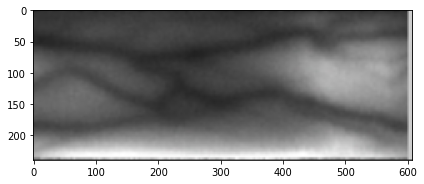

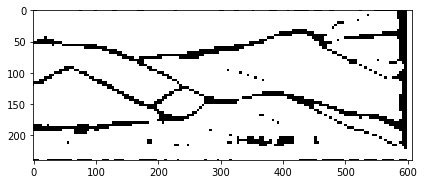

In [15]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [16]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [17]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

In [18]:
s.shape

TensorShape([Dimension(None), Dimension(240), Dimension(608), Dimension(3)])

In [19]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)
print(s)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
print("c1",c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
print("c1",c1)
p1 = MaxPooling2D((2, 2)) (c1)
print("p1",p1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
print("c2",c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
print("c2",c2)
p2 = MaxPooling2D((2, 2)) (c2)
print("p2",p2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
print("c3",c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
print("c3",c3)
p3 = MaxPooling2D((2, 2)) (c3)
print("p3",p3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
print("c4",c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
print("c4",c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
print("p4",p4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Tensor("lambda_2/truediv:0", shape=(?, 240, 608, 3), dtype=float32)
c1 Tensor("conv2d_1/Elu:0", shape=(?, 240, 608, 16), dtype=float32)
c1 Tensor("conv2d_2/Elu:0", shape=(?, 240, 608, 16), dtype=float32)

p1 Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 120, 304, 16), dtype=float32)
c2 Tensor("conv2d_3/Elu:0", shape=(?, 120, 304, 32), dtype=float32)
c2 Tensor("conv2d_4/Elu:0", shape=(?, 120, 304, 32), dtype=float32)
p2 Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 60, 152, 32), dtype=float32)
c3 Tensor("conv2d_5/Elu:0", shape=(?, 60, 152, 64), dtype=float32)
c3 Tensor("conv2d_6/Elu:0", shape=(?, 60, 152, 64), dtype=float32)
p3 Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 30, 76, 64), dtype=float32)
c4 Tensor("conv2d_7/Elu:0", shape=(?, 30, 76, 128), dtype=float32)
c4 Tensor("conv2d_8/Elu:0", shape=(?, 30, 76, 128), dtype=float32)
p4 Tensor("max_pooling2d_4/MaxPool:0", shape=(?, 15, 38, 128), dtype=float32)
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Us

In [29]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

Train on 117 samples, validate on 13 samples
Epoch 1/10
117/117 [==============================] - 166s 1s/step - loss: 0.3613 - mean_iou: 0.3514 - val_loss: 0.3892 - val_mean_iou: 0.4100

Epoch 00001: val_loss improved from inf to 0.38919, saving model to model-dsbowl2018-1.h5
Epoch 2/10
117/117 [==============================] - 199s 2s/step - loss: 0.3226 - mean_iou: 0.4227 - val_loss: 0.3815 - val_mean_iou: 0.4396

Epoch 00002: val_loss improved from 0.38919 to 0.38149, saving model to model-dsbowl2018-1.h5
Epoch 3/10
117/117 [==============================] - 172s 1s/step - loss: 0.3778 - mean_iou: 0.4414 - val_loss: 0.4373 - val_mean_iou: 0.4460

Epoch 00003: val_loss did not improve from 0.38149
Epoch 4/10
117/117 [==============================] - 223s 2s/step - loss: 0.3168 - mean_iou: 0.4504 - val_loss: 0.3365 - val_mean_iou: 0.4564

Epoch 00004: val_loss improved from 0.38149 to 0.33646, saving model to model-dsbowl2018-1.h5
Epoch 5/10
117/117 [==============================

In [30]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

118/118 [==============================] - 53s 453ms/step


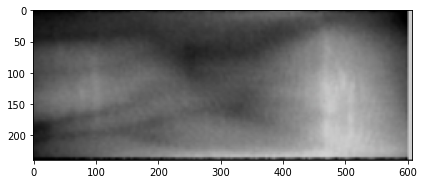

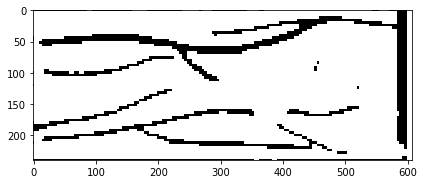

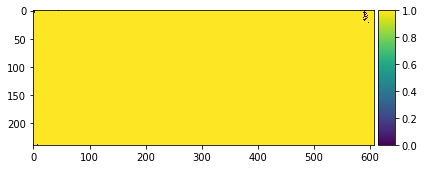

In [23]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

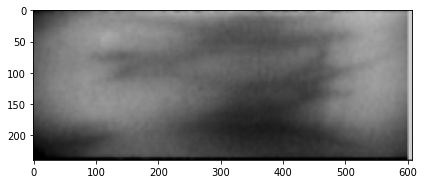

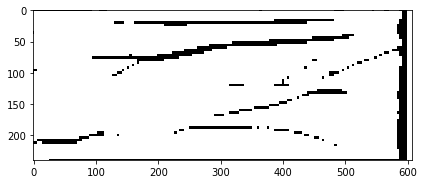

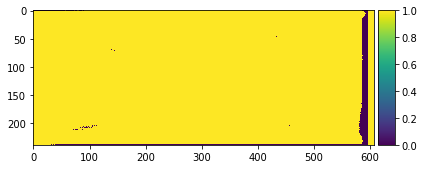

In [31]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [25]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [26]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [28]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)